# Рубежный контроль 2

## Тема: Методы построения моделей машинного обучения.

### Вариант 8

Построить модель классификаци/регрессии.  Для построения моделей используйте методы Опорных векторов и Градиентный бустинг.
Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Датасет https://www.kaggle.com/lava18/google-play-store-apps

In [1]:
import numpy as np
from numpy import array
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVR
import numpy as np
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

from sklearn.preprocessing import LabelEncoder, StandardScaler


from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [2]:
data = pd.read_csv('gps_data.csv', sep=",")

In [3]:
data.shape

(10841, 13)

In [4]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [5]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Видно, что есть пропуски, а значит датасет пока непригоден.

Поскольку рейтинг - количественный параметр, лучше будет удалить строки с отсутствующим рейтингом, тем более что их немного. То же самое можно сказать и об остальных пропусках.

In [6]:
data_new = data.dropna(axis=0, how='any')
data=data_new
print(f"было удалено {data.shape[0]-data_new.shape[0]} строк")

было удалено 0 строк


In [7]:
data_new.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

### Пропусков больше нет. Однако появляется проблема, в датасете всего 1 численное поле. Поэтому нужно перевести остальные поля в численный формат.

In [8]:
data_new.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [9]:
data_new.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [10]:
#мы не пишем обратно в датасеты, поэтому игнорируем предупреждение об изменении в копии
pd.options.mode.chained_assignment = None

In [11]:
#переводим количество ревью в числа
data_new['Reviews'].replace('M','000000', regex=True, inplace=True)
data_new['Reviews'] = pd.to_numeric(data_new['Reviews'], downcast='float')

In [12]:
#переводим количество загрузок в числа
data_new['Installs'].replace(',','', regex=True, inplace=True)
data_new['Installs'].replace('\D','', regex=True, inplace=True)
data_new['Installs'] = pd.to_numeric(data_new['Installs'], downcast='float')

In [13]:
#переводим цену в числа
data_new['Price'].replace('\D','', regex=True, inplace=True)
data_new['Price'] = pd.to_numeric(data_new['Price'], downcast='float')

In [14]:
#переводим размер в числа
data_new['Size'].replace('Varies with device','0', regex=True, inplace=True)
data_new['Size'].replace('\D','', regex=True, inplace=True)
data_new['Size'] = pd.to_numeric(data_new['Size'], errors='coerce', downcast='float')

In [15]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,87.0,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25.0,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,28.0,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [17]:
#заменяем varies vith device на среднее
mean = data_new['Size'].mean()
data_new['Size']=data_new.Size.mask(data.Size == 0,mean)

In [18]:
#создаем уникальные значения категорий
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
cat_enc_le = le.fit_transform(data_new.loc[:, 'Category'])
print(le.inverse_transform(np.unique(cat_enc_le)))
data_new.loc[:, 'Category'] = cat_enc_le

['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FAMILY' 'FINANCE' 'FOOD_AND_DRINK' 'GAME' 'HEALTH_AND_FITNESS'
 'HOUSE_AND_HOME' 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'MAPS_AND_NAVIGATION'
 'MEDICAL' 'NEWS_AND_MAGAZINES' 'PARENTING' 'PERSONALIZATION'
 'PHOTOGRAPHY' 'PRODUCTIVITY' 'SHOPPING' 'SOCIAL' 'SPORTS' 'TOOLS'
 'TRAVEL_AND_LOCAL' 'VIDEO_PLAYERS' 'WEATHER']


In [19]:
#создаем уникальные значения аудиторий
cat_enc_le = le.fit_transform(data_new.loc[:, 'Content Rating'])
print(le.inverse_transform(np.unique(cat_enc_le)))
data_new.loc[:, 'Content Rating'] = cat_enc_le

['Adults only 18+' 'Everyone' 'Everyone 10+' 'Mature 17+' 'Teen' 'Unrated']


In [20]:
cat_enc_le = le.fit_transform(data_new.loc[:, 'Current Ver'])
print(le.inverse_transform(np.unique(cat_enc_le)))
data_new.loc[:, 'Current Ver'] = cat_enc_le
cat_enc_le = le.fit_transform(data_new.loc[:, 'Android Ver'])
print(le.inverse_transform(np.unique(cat_enc_le)))
data_new.loc[:, 'Android Ver'] = cat_enc_le

['0.0.0.2' '0.0.1' '0.0.2' ... 'v8.0.1.8.0629.1' 'v8[1.0.10]'
 'version 0.994']
['1.0 and up' '1.5 and up' '1.6 and up' '2.0 and up' '2.0.1 and up'
 '2.1 and up' '2.2 and up' '2.3 and up' '2.3.3 and up' '3.0 and up'
 '3.1 and up' '3.2 and up' '4.0 and up' '4.0.3 - 7.1.1' '4.0.3 and up'
 '4.1 - 7.1.1' '4.1 and up' '4.2 and up' '4.3 and up' '4.4 and up'
 '4.4W and up' '5.0 - 6.0' '5.0 - 8.0' '5.0 and up' '5.1 and up'
 '6.0 and up' '7.0 - 7.1.1' '7.0 and up' '7.1 and up' '8.0 and up'
 'Varies with device']


In [21]:
#создаем уникальные значения типа
cat_enc_le = le.fit_transform(data_new.loc[:, 'Type'])
print(le.inverse_transform(np.unique(cat_enc_le)))
data_new.loc[:, 'Type'] = cat_enc_le

['Free' 'Paid']


In [22]:
data_new.drop(columns=['App', 'Last Updated', 'Genres'], inplace=True)

**Теперь все строки без пропусков и переведены в числовой формат**

In [23]:
data_new.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Current Ver       0
Android Ver       0
dtype: int64

In [24]:
data_new.dtypes

Category            int32
Rating            float64
Reviews           float32
Size              float32
Installs          float32
Type                int32
Price             float32
Content Rating      int32
Current Ver         int32
Android Ver         int32
dtype: object

In [25]:
col_num = data_new.dtypes[data_new.dtypes!=object].index.values.tolist()
se = StandardScaler()
data_new[col_num] = se.fit_transform(data[col_num])
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Current Ver,Android Ver
0,-2.029946,-0.178244,-0.163511,-0.402855,-0.196126,-0.272048,-0.06076,-0.477791,-1.324017,-0.372111
1,-2.029946,-0.566416,-0.163254,-0.463032,-0.190757,-0.272048,-0.06076,-0.477791,-0.364921,-0.372111
2,-2.029946,0.986272,-0.135735,0.415548,-0.141448,-0.272048,-0.06076,-0.477791,-0.964214,-0.372111
3,-2.029946,0.598100,-0.094991,-0.330643,0.351641,-0.272048,-0.06076,2.456672,1.485168,0.055911
4,-2.029946,0.209928,-0.163254,-0.294537,-0.195140,-0.272048,-0.06076,-0.477791,-1.161708,0.341259


### теперь проедем кореляционный анализ.

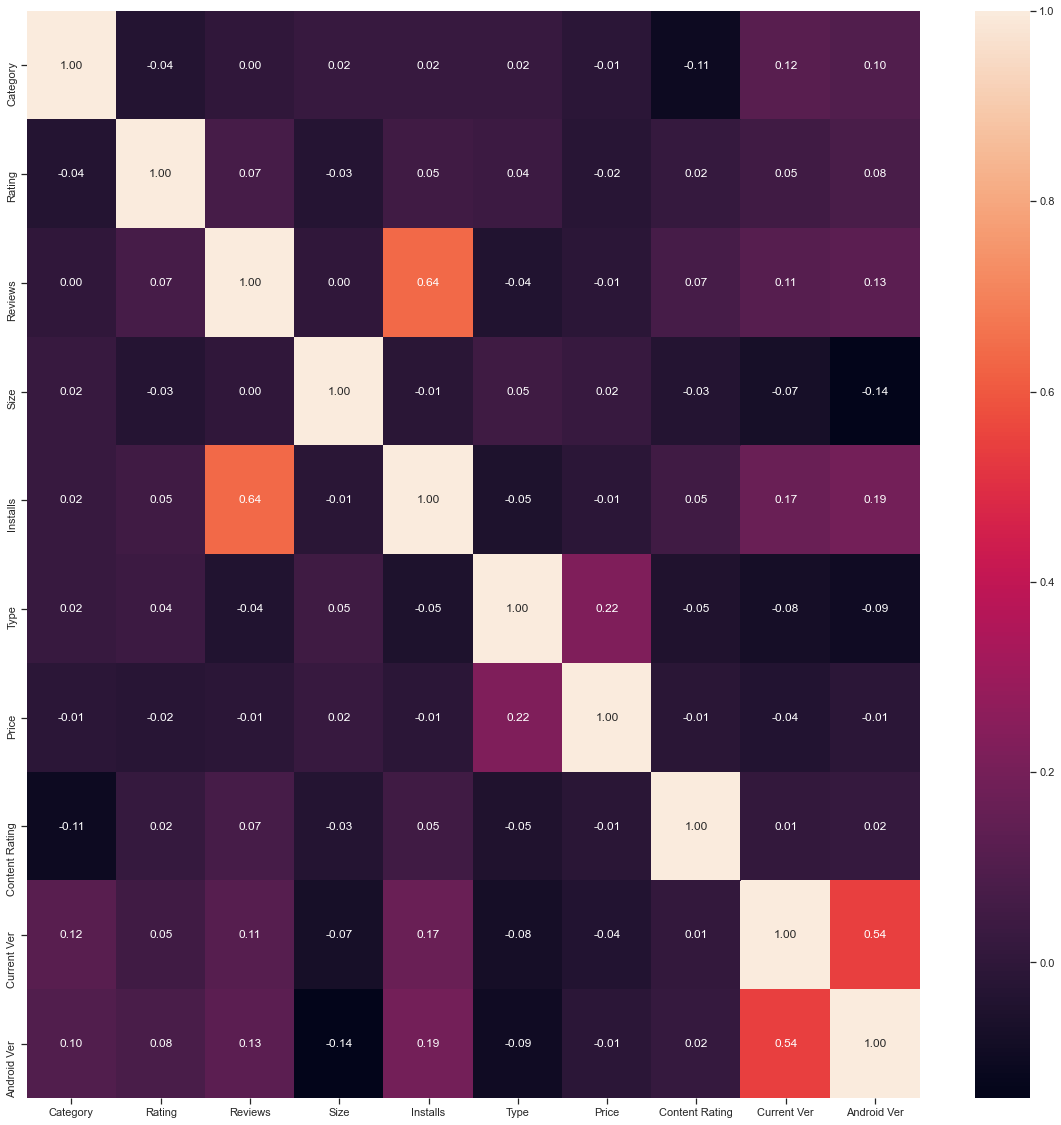

In [26]:
plt.figure(figsize=(20,20))
g = sns.heatmap(data.corr(), annot=True, fmt='.2f')

## Приступаем к работе над моделью

In [27]:
TEST_SIZE = 0.3
RANDOM_STATE = 1
data_X = data.drop(columns='Installs')
data_Y = data['Installs']
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split \
(data_X, data_Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [28]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    with suppress_stdout():
        clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = (mean_squared_error(Y_test, target), mean_absolute_error(Y_test, target), r2_score(Y_test, target))
    print(f'MSE: {ret[0]}, MeanAE: {ret[1]}, R2: {ret[2]}' )
    return ret

def plot_learning_curve(data_X, data_y, clf, score, name):
    with suppress_stdout():
        train_sizes, train_scores, test_scores = learning_curve(estimator=clf, scoring=score, X=data_X, y=data_y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=f'тренировочная {name}-мера')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
             label=f'проверочная {name}-мера')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel('Число тренировочных образцов')
    plt.ylabel(f'{name}-мера')
    plt.show()

## Метод опорных векторов

In [29]:
SVR_full = print_metrics(data_X_train, data_Y_train,  data_X_test, data_Y_test, SVR(kernel='poly'))

MSE: 0.825063486359171, MeanAE: 0.1689811937411203, R2: 0.21397516802137562


SVR даже через RandomizedSearch падает

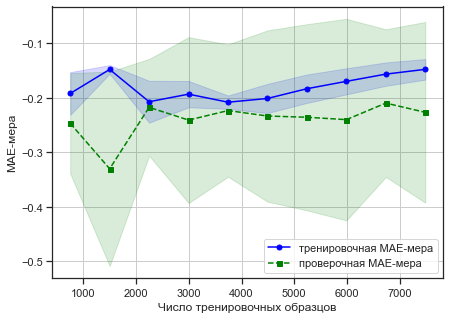

In [30]:
plot_learning_curve(data_X, data_Y, SVR(kernel='poly'), score = 'neg_mean_absolute_error', name='MAE')

## Метод градиентного бустинга

In [31]:
gb = CatBoostRegressor(random_state=RANDOM_STATE, eval_metric = 'MAE')

In [32]:
boost_metric = print_metrics(data_X_train, data_Y_train, data_X_test, data_Y_test, CatBoostRegressor(random_state=RANDOM_STATE, eval_metric = 'MAE'))

MSE: 0.09100851347792337, MeanAE: 0.06239913856578352, R2: 0.9132976398812926


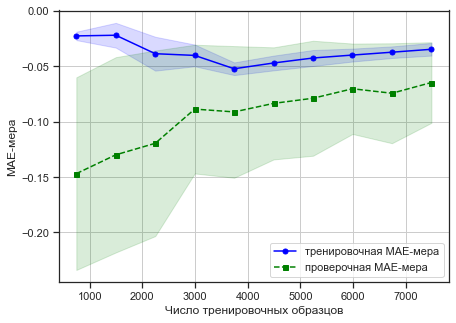

In [33]:
plot_learning_curve(data_X, data_Y, gb, score = 'neg_mean_absolute_error', name='MAE')

# Итог

В РК были использованы метрики MAE, MSE, R2

MAE и MSE помогают определить точность регрессии - среднее отклонение и дисперсию.

R2 позволяет оценить общее качество модели, чем R2 ближе у 1, тем модель лучше.

Метод градиентного бустинга показал себя гораздо лучше в сравнении с методом опорных векторов. Можно логично предположить, что это является следствием слаюой связности датасета. Поэтому метрика R2 мала у метода ОВ. Зато весовые коэффициенты в методе бустинга позволяют улучшить данный показатель и добиться куда большей точности и качества модели.